### Table of Contents <a id= "toc"> </a>
<pre>
[1. Importing Data, EDA and corpus list](#eda) <br>
[2. Cleaning Dataset](#clean)<br>
   [2.1. Stopwords](#2.1)<br>
       [a. Adding business stopwords](#2.1.a)<br>
       [b. Computing rare occuring words from IDF scores](2.1.b)<br>
    [2.2. Stemming](#2.2)<br>
    [2.3. Lemmatization](#2.3)<br>
    [2.4. Extract words](#2.4)<br>
[3. Bag of Words (BOW) reprentation](#3)<br>
[4. IDF](#4)<br>
[5. TFIDF](#5)<br>
[6. Building a Vocab](#6)<br>
[7. Term- document matrix](#7)<br>
[8. NLP on reviews](#8)<br>
[9. Sentiment Classifier](#9)<br>

## Importing Dataset and EDA <a id="eda"></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import string
import datetime as dt
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from numpy.linalg import svd
from numpy import diag
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

from pprint import pprint

In [ ]:
# Importing data
df= pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv", index_col=0)
df.columns= df.columns.str.replace(" ", "_")
df.head()
df.isnull().sum()

In [ ]:
corpus_list = list(df[df.Review_Text.notnull()]["Review_Text"])
# Reducing corpus to reduce running time
corpus_list= corpus_list[:500]

corpus_list[:5]

### STOPWORDS <a id="2.1"></a>

In [ ]:
import nltk
from nltk.corpus import stopwords

stoplist= stopwords.words('english')
stoplist[:5]

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

wordnet_lemmatizer= WordNetLemmatizer()

def get_pos_tag(tag):
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN #default case

stemming

study, studying- study
player, player, playing- play

In [ ]:
def preprocess(doc, stopwords):
    """ 1. Removes Punctuations
        2. Removes Stopwords
        3. Converts into lowercase
        4. Lemmatizes words
    """
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(doc)    
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or word in stoplist or len(word)<3)]
    
    #lemmatize    
    pos_tags=nltk.pos_tag(word_tokens)
    doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]
    
    return doc_words

In [ ]:
#This Function will return 10 examples of reviews containing that particular word
def documents_which_have(word, document_list, stoplist): #since stoplist is globally defined we don't really need to pass it within every function!
    
    print("Documents which contains the word '", word, "' are: ")
    example_counter=0
    document_words=[]
    for document in document_list:
        document_words=preprocess(document,stoplist)
        
        word_set= set(document_words)
        if word in word_set:
            print(document,"\n")
            example_counter+=1
        
        if example_counter==5:
            break
        
# Function Call:
# documents_which_have("summer",corpus_list, stoplist)

### Manually adding business stopwords <a id ="2.1.a"></a>

Few words would be helpful in sentiment analysis and hence we will not consider them as stopwords (ex: 'really',"much" can be used a valence modifier!)

Checkout the "documents_which_have" function to justify the new business stopwords addition!
ex: "one"- used in contexts such as: "the one", "this one", "tricky one"

Need to use lemmatizers to combine all variations- ex: fit/fits, wear/wearing, look/looking
also similar meaning words like buy/bought/purchased

In [ ]:
#Selecting business stopwords
business_stopwords= ["i'm","would", "look", "ordered", "wear", "fit", "one", "fits","bought", "looks", "also", "got", "think", "even",
                     "tried", "get", "could", "made","way","still", "runs","true" ,"right", "see","online","wearing", "however", "design","purchased","feel","go",
                     "enough","model","though","price","looked","person","better","first","going","try", "body" "bottom","time","many","looking","around","thought",
                     "make","wanted","saw","makes","went","find","found","buy","nan","i've", "since","seems","ok", "girl", "woman"]

stoplist= stoplist+business_stopwords
print("New length of stoplist after addition of manually defined stopwords: ", len(stoplist))

### Cleaning Dataset <a id="clean"></a>

#### Word Normalization Techniques: Lemmatization <a id ="2.2"></a>
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.
<br>
**Lemmatization**, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. 

In [ ]:
a= "running ran geese playing with cats"
preprocess(a, stoplist)
# nltk.pos_tag(nltk.word_tokenize(a))

In [ ]:
#Creating a list of all words present in all reviews: i.e: word_list
word_list=[]

for sentence in corpus_list:
        word_list.extend(preprocess(sentence,stoplist))
        word_list= list(set(word_list))

print("Total no. of unique words present in our corpus are:", len(word_list))

### Bag of words Representation <a id ="3"></a>

# 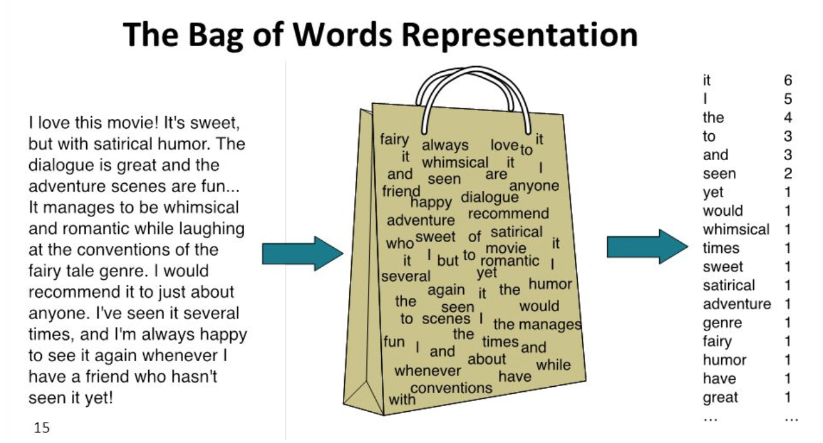

In [ ]:
#Onefunction to return word_list(sorted bog), and corpus
def BOW_model(sentence_list, stoplist):
    
    sentence_words=[]
    total_count={}
    
    for sentence in sentence_list:
        sentence_words.append(preprocess(sentence, stoplist))
        
        word_set= set(sentence_words[-1]) #Pick the most recent sentence
        for word in word_set:
            total_count[word]= total_count.get(word,0)+1
            
    sorted_bog= sorted(list(total_count.items()), key=lambda x:x[1] ,reverse= True)
    return sorted_bog, sentence_words

sorted_bog, corpus_words= BOW_model(corpus_list, stoplist)

print(f"Total unique words in our corpus:{len(sorted_bog)},\n sorted bog:{sorted_bog[:10]}")

### Inverse Document Frequency(IDF) <a id ="4"></a>

**One way of determining the relative importance of a word is to see how often it appears across multiple documents. Words that are relevant to a specific topic are more likely to appear in documents about that topic and much less in documents about other topics (TF). On the other hand, less meaningful words (like the) will be common across documents about any subject.(IDF)**

In [ ]:
def inv_doc_freq(corpus_words):
    number_docs= len(corpus_words)
    
    document_count={}
    
    for document in corpus_words:
        word_set= set(document)
        
        for word in word_set:
            document_count[word]= document_count.get(word,0)+1
            
    IDF={}
    
    for word in document_count:
        IDF[word]= np.log(number_docs/document_count[word])
        
    return IDF

IDF= inv_doc_freq(corpus_words)
sorted_IDF= sorted(list(IDF.items()), key=lambda x:x[1])
print("Calibrating IDF scores. \n Top IDF scores representing rarely occuring words:\n ",sorted_IDF[-10:])

### Computing rare words  <a id ="2.1.b"></a>

We consider words that occur only once (thus have highest IDF) as rare.

In [ ]:
rare_review_words= [t[0] for t in sorted_IDF if round(t[1])==round(max(IDF.values()))] #Using List comprehension!
len(rare_review_words)

**55% of words in the vocab appear to have occured only once and are either typos/carry redundant information- Rare review words!**

<pre>
**Observation**
IDF is said to measure the informativeness of the word. It will be very low for the most occurring words such as stop words.
However the high IDF words, which are really rare occurences- may also be mistakes- and could be irrelevant.
It is very noticiable from above that words with highest IDF scores seem to have Incorrect spelling and less importance.
Hence we can probably remove the top IDF words, based on their TF-IDF scores, also we can manually check the sentences they appear in to verify their importance using the function:
example: 
documents_which_have("grrrrrrrrrrr",list(df.Review_Text), stoplist)

In [ ]:
#Recomputing stoplist
stoplist= stoplist+ rare_review_words

#Recomputing Bag of words and Corpus words:
sorted_bog, corpus_words= BOW_model(corpus_list, stoplist)
print("The rare words are removed from our corpus and the new list of bog now contains", len(sorted_bog),"unique words!")
len(sorted_bog), len(corpus_words)

### TF-IDF <a id ="5"></a>

In [ ]:
def tf_idf(corpus_words):
    IDF= inv_doc_freq(corpus_words)
        
    TFIDF=[]
    
    for document in corpus_words:
        TFIDF.append(Counter(document))
    
    for document in TFIDF:
        for word in document:
            document[word]= document[word]* IDF[word]
    
    return TFIDF

TFIDF= tf_idf(corpus_words)
TFIDF[:2]

In [ ]:
word_list=[]

for sentence in corpus_list:
        word_list.extend(preprocess(sentence,stoplist))
        word_list= list(set(word_list))

print("Total no. of unique words present in our corpus are:", len(word_list))


High values of **TF-IDF** represent that they have occurence only in that specific document, now it could be a mistake/typo or could be an important topic only for that document.<br>
In the above cases: <br>
High Values- typo- "sooo","happened","bc" <br>
High Values- important for topic - "petite","silky"

In [ ]:
def build_vocabulary(TFIDF):
    word_set= set()
    
    for document in TFIDF:
        for key in document:
            word_set.add(key)
            ## set add will add the element only if it isn't already present
    
    word_dict= dict(zip(word_list, range(len(word_list))))
    
    return word_dict

word_dict= build_vocabulary(TFIDF)
word_dict

### Term-Document Matrix <a id ="7"></a>
Now use the TFIDF matrix and our vocabulary to generate the Term Document matrix. This is just a matter of rearranging the values in our (sparse) TFIDF matrix into the full TD matrix.

In [ ]:
def term_document_matrix(corpus_words):
    
    """ This TDM contains word frequency for every (word, document) pair"""
    
    tdm=[]
    
    cv= CountVectorizer(tokenizer= lambda doc:doc, lowercase=False, ngram_range=(1,1))
    
    tdm= cv.fit_transform(corpus_words)
    
    feature_names= cv.get_feature_names()
    
    return np.transpose(tdm), feature_names    

tdm, feature_names= term_document_matrix(corpus_words)

print("Our dataset has:\n%u unique words\n%u documents"%(tdm.shape))

In [ ]:
tdm.shape

In [ ]:
def term_document_matrix_TFIDF(TFIDF, word_list, word_dict):   #Length of both the TD matrix should be the same!
    
    """ This TDM contains the TFIDF score for every (word, document) pair """
    vocabulary_size = len(word_dict)
    number_documents = len(TFIDF)
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]

        for word in document.keys():
            pos= word_dict.get(word,-1) #To handle cases: words which have been removed from word dict(as they were rare words!)
            if pos==-1:
                continue

            TDM[pos, doc] = document[word]
    
    return TDM

TDM_tfidf = term_document_matrix_TFIDF(TFIDF, word_list, word_dict)
print("Our dataset has:\n%u unique words\n%u documents"%(TDM_tfidf.shape))

## NLP on Women's clothing reviews <a id ="8"></a>
1. Extract all the numbers. Check what % of ladies have indeed mentioned their weights and what is their average rating or major keywords? all reviews where women have mentioned their weights(search for letter- lb/lbs or a 3 digit number) and heights. - Can be done using REGEX
2. Recommendation Prediction
3. Extract Semantically related words- Extract reviews related to a single review- ESA
4. Is there any correlation between user's rating and reviews length ?

df['Review Text']=df['Review Text'].astype(str) <br>
df['Review Length']=df['Review Text'].apply(len)

- Is it possible to identify such a thing as: Women above 40 who is really happy will write more or equal to women below 40. Women above 40 will write a smaller review when they are pissed off with a product, compared to a younger lady who will critisize a product in detail.

### Explicit Semantic Analysis/ Find related documents
In ESA we make use of the TD matrix of our corpus as a knowledge base that we can use to look up related documents.

In [ ]:
new_review= ['great','fit','pink','skirt']

In [ ]:
def find_related_docs(review, TDM):
    new_vector= np.zeros(TDM.shape[1])
    
    for word in review:
        pos= word_dict.get(word,-1)
        if pos==-1:
            continue
        new_vector+= TDM[pos,:]
        
    # After the loop completion, new_vector will tell us which documents are activated by this word!
    # Let's extract the list of documents sorted by activation
    
    doc_list= sorted(zip(range(TDM.shape[1]), new_vector), key= lambda x:x[1], reverse=True)
    
    return doc_list

related= find_related_docs(new_review, TDM_tfidf)
related[:3]

In [ ]:
#Let's look at the top 5 results
print("Top 5 reviews related to ", new_review, "are: \n")
for review, score in related[:3]:
    print(round(score), review, " ".join(corpus_words[review]),"\n")

### Building a Sentiment Classifier <a id ="9"></a> <br>

Given a new review text, you will be able to accurately classify it into positive or negative sentiment, having a model being trained on both classes. This is similar to Spam or Not-Spam classifier in gmail.

In [ ]:
df.loc[(df.Recommended_IND==1), 'Rating'].value_counts(normalize= True)

In [ ]:
df.loc[(df.Recommended_IND==0), 'Rating'].value_counts(normalize= True)

Looking above, it is evident that Recommended_IND classifies 4 and 5 Rating as positive sentiment(1) and 1,2,3 as negative sentiment(0).

In [ ]:
from sklearn.model_selection import train_test_split
df.dropna(subset=['Review_Text'], inplace=True)
x= df['Review_Text']
y= df['Recommended_IND']

In [ ]:
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)

# sorted_bog, corpus_words= BOW_model(corpus_list, stoplist)
train_bow, train_corpus= BOW_model(train_data['Review_Text'], stoplist)
test_bow, test_corpus= BOW_model(test_data['Review_Text'], stoplist)


vectorizer= CountVectorizer(tokenizer= lambda doc:doc, lowercase=False, ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_corpus)
y_train = train_data['Recommended_IND']
x_test = vectorizer.transform(test_corpus)
y_test = test_data['Recommended_IND']

x_train.shape, x_test.shape, y_train.shape, y_test.shape

Logistic Regression

In [ ]:
start= dt.datetime.now()
lr=LogisticRegression()
lr.fit(x_train, y_train)
print("Elapsed time:", str(dt.datetime.now()- start))

Naive Bayes

In [ ]:
start= dt.datetime.now()
nb= MultinomialNB()
nb.fit(x_train, y_train)
print("Elapsed time:", str(dt.datetime.now()- start))

Support Vector Machine (SVM)

In [ ]:
start= dt.datetime.now()
svm= SVC()
svm.fit(x_train, y_train)
print("Elapsed time:", str(dt.datetime.now()- start))

Neural Network

In [ ]:
start= dt.datetime.now()
nn= MLPClassifier()
nn.fit(x_train, y_train)
print("Elapsed time:", str(dt.datetime.now()- start))

### Evaluating Models

In [ ]:
#Define a dataframe for the prediction probabilities of the model
df2= train_data.copy()
df2['Logistic_Regression']= lr.predict(x_train)
df2['Naive_Bayes']= nb.predict(x_train)
df2['SVM']= svm.predict(x_train)
df2['Neural_network']= nn.predict(x_train)
df2.head()

### ROC Curve and AUC

In [ ]:
pred_lr= lr.predict_proba(x_test)[:,1]
fpr_lr, tpr_lr,_= roc_curve(y_test, pred_lr)
roc_auc_lr= auc(fpr_lr, tpr_lr)

pred_nb= nb.predict_proba(x_test)[:,1]
fpr_nb, tpr_nb,_= roc_curve(y_test, pred_nb)
roc_auc_nb= auc(fpr_nb, tpr_nb)

pred_svm= svm.decision_function(x_test)
fpr_svm, tpr_svm,_= roc_curve(y_test, pred_svm)
roc_auc_svm= auc(fpr_svm, tpr_svm)

pred_nn= nn.predict_proba(x_test)[:,1]
fpr_nn, tpr_nn,_= roc_curve(y_test, pred_nn)
roc_auc_nn= auc(fpr_nn, tpr_nn)

f, axes = plt.subplots(2, 2,figsize=(15,10))

axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Neural Network')
axes[1,1].legend(loc='lower right', fontsize=13)

### Confusion Matrix

In [ ]:
# preparation for the confusion matrix
lr_cm=confusion_matrix(y_test.values, lr.predict(x_test))
nb_cm=confusion_matrix(y_test.values, nb.predict(x_test))
svm_cm=confusion_matrix(y_test.values, svm.predict(x_test))
nn_cm=confusion_matrix(y_test.values, nn.predict(x_test))

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,2,1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,4)
plt.title("Neural Network")
sns.heatmap(nn_cm, annot = True, cmap="Greens",cbar=False);

### Precision - Recall - F1-Score

In [ ]:
import sklearn.metrics as mt

print("Logistic Regression")
print(mt.classification_report(y_test, lr.predict(x_test)))
print("\n Naive Bayes")
print(mt.classification_report(y_test, nb.predict(x_test)))
print("\n Support Vector Machine (SVM)")
print(mt.classification_report(y_test, svm.predict(x_test)))
print("\n Neural Network")
print(mt.classification_report(y_test, nn.predict(x_test)))

**More coming up! Please upvote if you find it intuitive and helpful. Take care!**

### Latent Semantic Analysis
LSA analysis, sometimes refered to as Latent Semantic Indexing, relies on the well known Singular Value Decomposition. Singular Values (and Singular Vectors) can be thought of as being a generalization of the more common eigenvalues (and eigenvectors) for the case of non-square matrices.

In [ ]:
u, sigma, vt= svd(TDM_tfidf)

The resulting matrices have the expected shapes, except the singular value matrix, sigma that is simply a vector. This is an optimization of the numpy function meant to save memory.

In [ ]:
m,n = TDM_tfidf.shape
print(u.shape, sigma.shape, vt.shape, m, n)

We can now reduce the internal dimension of these matrices to say, 10

In [ ]:
k=10

#Convert the vector of singular values into a diagonal matrix
sigma_k= sigma[:k]
Sk= diag(sigma_k)

#Drop the extraneaous dimensions in the other two matrices
uk= u[:,:k]
vtk= vt[:k,:]

print(uk.shape, Sk.shape, vtk.shape)

In this way, we preserve the most significant (higher sigma values) latent dimensions of the dataset while discarding the rest. The idea is simple, SVD projects the original dataset into an internal space which is a linear combination of the original one. Each dimension in this space can be thought of as an underlying topic in the data. By preserving only the most dominant topics in effect we are simplifying the data and, potentially, removing noise.